## 1. Environment Setup & Data Loading

In [7]:
import pandas as pd
import numpy as np
import ast
df = pd.read_csv("Project 4_data.csv")
print(df.head(10))


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private    

## 2. Data Preprocessing

In [10]:
#Copying the Original dataframe to preserve raw data
df_clean = df.copy()
#Checking for missing values in each column
print("Missing values per column : \n", df_clean.isnull().sum())


Missing values per column : 
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [12]:
#Imputing the null values in the bmi column with the median of the column
median_bmi = df_clean['bmi'].median()
df_clean['bmi'] = df_clean['bmi'].fillna(median_bmi)
df['stroke'] = pd.to_numeric(df['stroke'], errors='coerce').fillna(0).astype(int)
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['avg_glucose_level'] = pd.to_numeric(df['avg_glucose_level'], errors='coerce')

#Dropping the id column as it doesn't contribute to the prediction
df_clean = df_clean.drop(columns = ['id'])

#Converting the categorical values to numerical value by one-hot coding
categorical_cols = [
    'gender',        # Male/Female/Other
    'ever_married',  # Yes/No
    'work_type',     # children, Govt_job, etc
    'Residence_type',# Rural/Urban
    'smoking_status' # formerly smoked, never smoked, etc
]

df_clean = pd.get_dummies(df_clean, columns = categorical_cols, drop_first = True) # drop first level to avoid dummy variable trap

print("Shape of the cleaned/pre-processed dataframe:\n ", df_clean.shape) #Printing the shape of the dataframe
print ("First 10 values of cleaned/pre-processed dataframe:\n ", df_clean.head(10)) # Printing the head of the cleaned dataframe

Shape of the cleaned/pre-processed dataframe:
  (5110, 17)
First 10 values of cleaned/pre-processed dataframe:
      age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
1  61.0             0              0             202.21  28.1       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   
5  81.0             0              0             186.21  29.0       1   
6  74.0             1              1              70.09  27.4       1   
7  69.0             0              0              94.39  22.8       1   
8  59.0             0              0              76.15  28.1       1   
9  78.0             0              0              58.57  24.2       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0        

## 3. Exploratory Data Analysis

<Figure size 600x400 with 0 Axes>

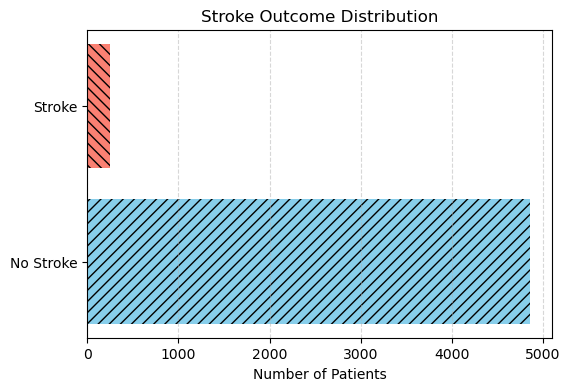

 The dataset is highly imbalanced—~95% of patients did not have a stroke.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
#  1. Stroke Outcome Distribution
plt.figure(figsize=(6,4))
fig, ax = plt.subplots(figsize=(6,4))
labels = ['No Stroke','Stroke']
counts = df['stroke'].value_counts().sort_index()
bars = ax.barh(labels, counts, color=['skyblue','salmon'])
hatches = ['///','\\\\\\']
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
ax.set_xlabel('Number of Patients')
ax.set_title('Stroke Outcome Distribution')
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()
print(" The dataset is highly imbalanced—~95% of patients did not have a stroke.")





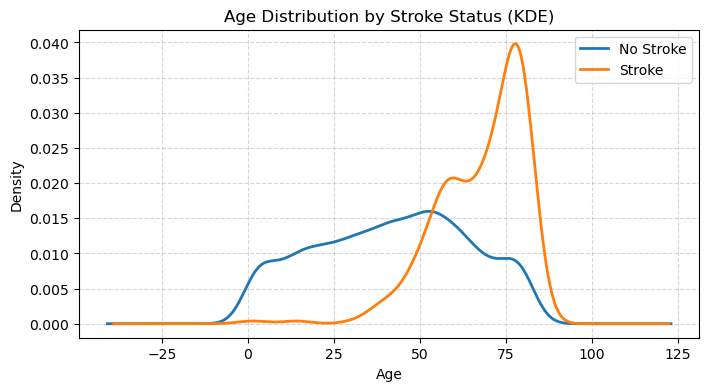

Stroke patients skew older, with density peaking above 60 years.


In [16]:
#  2. Age Distribution by Stroke Status
plt.figure(figsize=(8,4))
df[df['stroke']==0]['age'].plot.kde(label='No Stroke', linewidth=2)
df[df['stroke']==1]['age'].plot.kde(label='Stroke', linewidth=2)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Stroke Status (KDE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print("Stroke patients skew older, with density peaking above 60 years.")

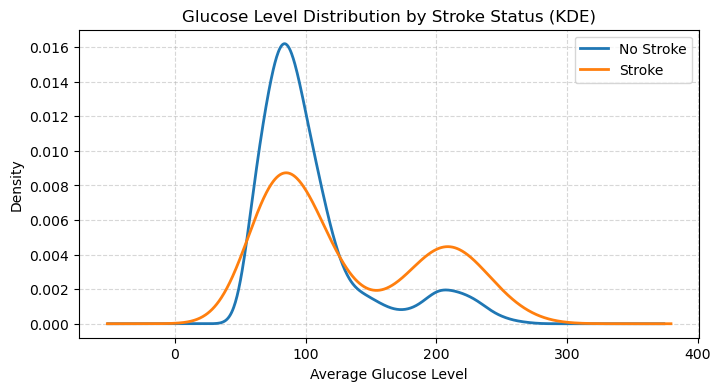

Stroke patients show a heavier tail at higher glucose levels (>150 mg/dL).


In [17]:
# 3. Glucose Level Distribution by Stroke Status
plt.figure(figsize=(8,4))
df[df['stroke']==0]['avg_glucose_level'].plot.kde(label='No Stroke', linewidth=2)
df[df['stroke']==1]['avg_glucose_level'].plot.kde(label='Stroke', linewidth=2)
plt.xlabel('Average Glucose Level')
plt.ylabel('Density')
plt.title('Glucose Level Distribution by Stroke Status (KDE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print("Stroke patients show a heavier tail at higher glucose levels (>150 mg/dL).")

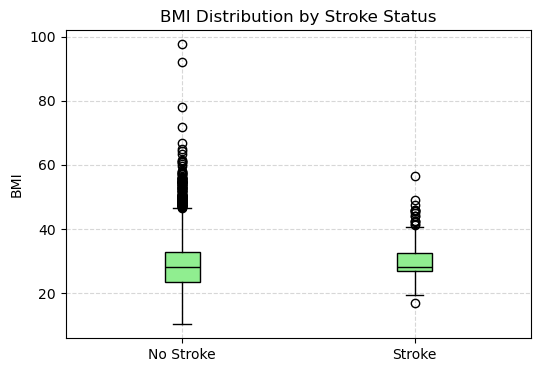

 Stroke patients have a slightly higher median BMI, but distributions overlap greatly.


In [18]:
# 4. BMI Distribution by Stroke Status 
plt.figure(figsize=(6,4))
plt.boxplot([df_clean[df_clean['stroke']==0]['bmi'],
             df_clean[df_clean['stroke']==1]['bmi']],
            labels=['No Stroke','Stroke'],
            patch_artist=True,
            boxprops=dict(facecolor='lightgreen'),
            medianprops=dict(color='black'))
plt.ylabel('BMI')
plt.title('BMI Distribution by Stroke Status')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print(" Stroke patients have a slightly higher median BMI, but distributions overlap greatly.")


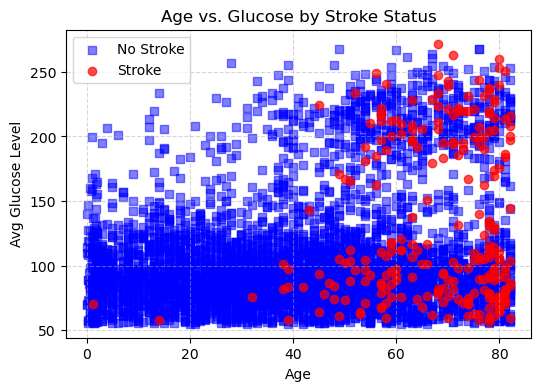

Stroke cases cluster in higher age and glucose regions.


In [19]:
# 5. Age vs. Glucose Scatter by Stroke Status 
plt.figure(figsize=(6,4))
plt.scatter(df[df['stroke']==0]['age'], df[df['stroke']==0]['avg_glucose_level'],
            c='blue', marker='s', alpha=0.5, label='No Stroke')
plt.scatter(df[df['stroke']==1]['age'], df[df['stroke']==1]['avg_glucose_level'],
            c='red', marker='o', alpha=0.7, label='Stroke')
plt.xlabel('Age')
plt.ylabel('Avg Glucose Level')
plt.title('Age vs. Glucose by Stroke Status')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print("Stroke cases cluster in higher age and glucose regions.")

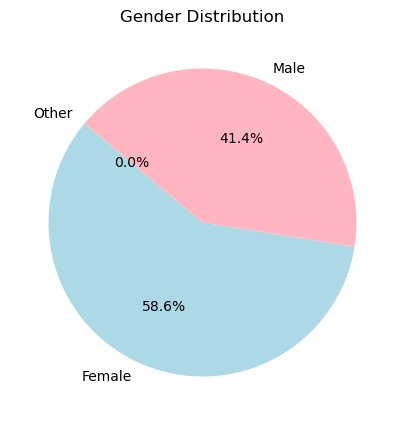

 Majority are Female, then Male; 'Other' is minimal.


In [20]:
# 6. Gender Distribution 
plt.figure(figsize=(5,5))
plt.pie(df['gender'].value_counts(),
        labels=df['gender'].value_counts().index,
        autopct='%1.1f%%', startangle=140,
        colors=['lightblue','lightpink','lightgray'])
plt.title('Gender Distribution')
plt.show()
print(" Majority are Female, then Male; 'Other' is minimal.")

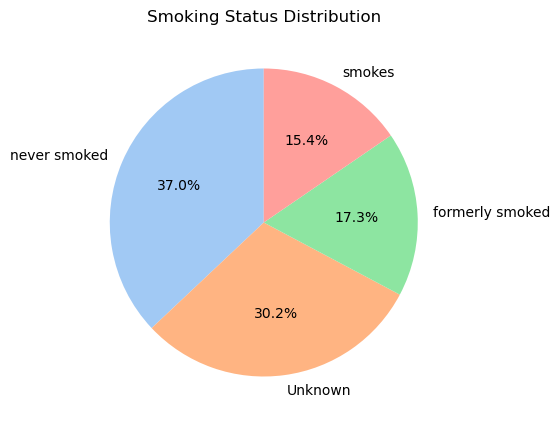

 Most never smoked; former/current smokers and 'Unknown' form the rest.


In [21]:
# 7. Smoking Status Distribution 
plt.figure(figsize=(5,5))
plt.pie(df['smoking_status'].value_counts(),
        labels=df['smoking_status'].value_counts().index,
        autopct='%1.1f%%', startangle=90,
        colors=sns.color_palette("pastel"))
plt.title('Smoking Status Distribution')
plt.show()
print(" Most never smoked; former/current smokers and 'Unknown' form the rest.")


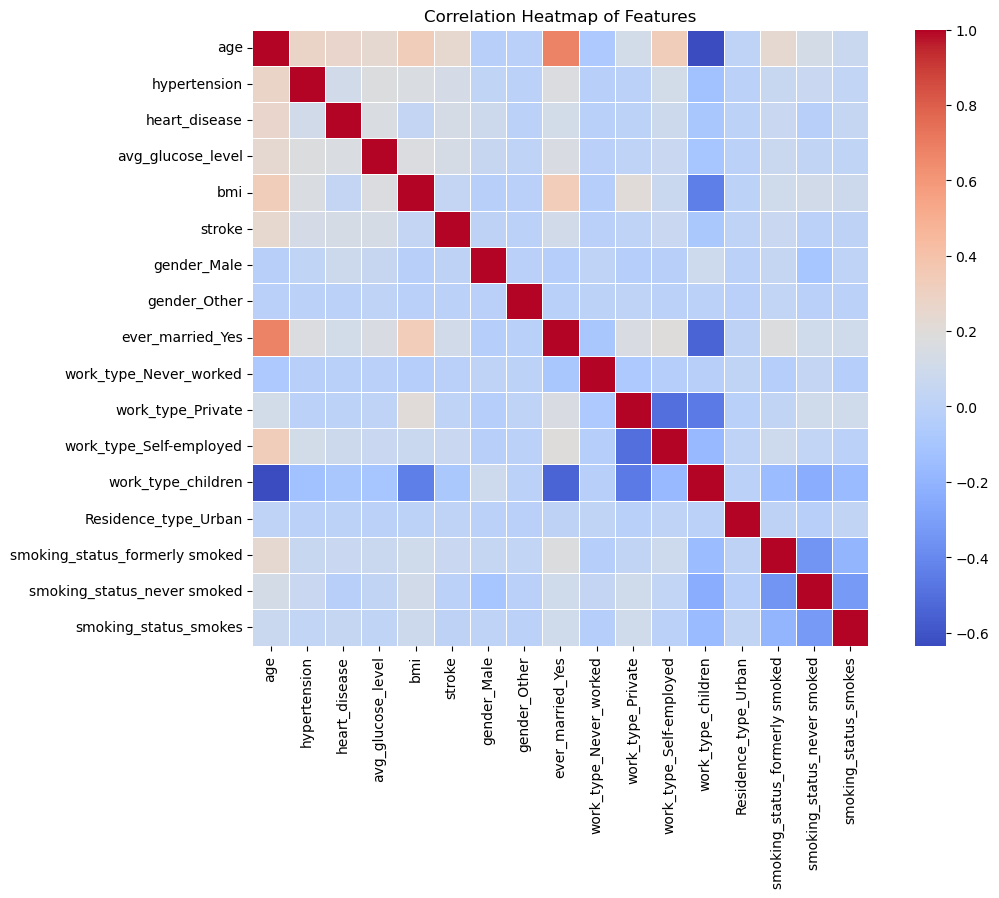

Age, hypertension, and glucose level show strongest positive correlation with stroke.


In [23]:
# 8. Correlation Heatmap 
plt.figure(figsize=(12,8))
sns.heatmap(df_clean.corr(), cmap='coolwarm', square=True, linewidths=0.4)
plt.title('Correlation Heatmap of Features')
plt.show()
print("Age, hypertension, and glucose level show strongest positive correlation with stroke.")

## 4. Feature Engineering and Data Preparation

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Age group bins
age_bins = [0, 18, 35, 50, 65, df_clean['age'].max()]
age_labels = ['child', 'young_adult', 'adult', 'senior', 'elderly']
df_clean['age_group'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=False)
df_clean = pd.get_dummies(df_clean, columns=['age_group'], drop_first=True)

# 2. BMI categories
bmi_bins = [0, 18.5, 25, 30, df_clean['bmi'].max()]
bmi_labels = ['underweight', 'normal', 'overweight', 'obese']
df_clean['bmi_category'] = pd.cut(df_clean['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)
df_clean = pd.get_dummies(df_clean, columns=['bmi_category'], drop_first=True)

# 3. Glucose categories
glucose_bins = [
    df_clean['avg_glucose_level'].min(), 70, 100, 125, 200, df_clean['avg_glucose_level'].max()
]
glucose_labels = ['low', 'normal', 'prediabetes', 'high', 'very_high']
df_clean['glucose_category'] = pd.cut(df_clean['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels, right=False)
df_clean = pd.get_dummies(df_clean, columns=['glucose_category'], drop_first=True)

# 4. Comorbidity count
df_clean['comorbidity_count'] = df_clean['hypertension'] + df_clean['heart_disease']

# 5. Interaction feature: age × avg_glucose_level
df_clean['age_glucose_interaction'] = df_clean['age'] * df_clean['avg_glucose_level']

# 6. Scale continuous features
scaler = StandardScaler()
continuous_feats = ['age', 'avg_glucose_level', 'bmi', 'comorbidity_count', 'age_glucose_interaction']
df_clean[continuous_feats] = scaler.fit_transform(df_clean[continuous_feats])

# Preview engineered dataset
print("After feature engineering, dataframe shape:", df_clean.shape)
print(df_clean[continuous_feats + ['stroke']].head())

After feature engineering, dataframe shape: (5110, 30)
        age  avg_glucose_level       bmi  comorbidity_count  \
0  1.051434           2.706375  1.005086           2.165256   
1  0.786070           2.121559 -0.098981          -0.386510   
2  1.626390          -0.005028  0.472536           2.165256   
3  0.255342           1.437358  0.719327          -0.386510   
4  1.582163           1.501184 -0.631531           2.165256   

   age_glucose_interaction  stroke  
0                 2.701380       1  
1                 1.932060       1  
2                 0.937722       1  
3                 0.916263       1  
4                 2.297911       1  


### *Train-Test Split*

In [33]:
from sklearn.model_selection import train_test_split

# Train-test split

X = df_clean.drop(columns=['stroke'])
y = df_clean['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Confirming the split
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Stroke ratio in full dataset:", y.mean())
print("Stroke ratio in training set:", y_train.mean())
print("Stroke ratio in test set:", y_test.mean())

Training set shape: (3577, 29)
Test set shape: (1533, 29)
Stroke ratio in full dataset: 0.0487279843444227
Stroke ratio in training set: 0.048644115180318706
Stroke ratio in test set: 0.04892367906066536


### *Evaluation Template Setup*

In [38]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define reusable evaluation function
def evaluate_model(model, X_test, y_test, model_name, results_list):
    # 1. Predictions and Probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probability for class 1 (stroke)
    
    # 2. Classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, digits=3))
    
    # 3. ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.3f}")
    
    # 4. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # 5. ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # 6. Save metrics for comparison
    report = classification_report(y_test, y_pred, output_dict=True)
    results_list.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-score': report['1']['f1-score'],
        'ROC-AUC': roc_auc
    })

# Placeholder list to collect results
evaluation_results = []

print("Evaluation template is ready!")

Evaluation template is ready!


## 5. Modeling & Evaluation

### *5.1 Logistic Regression*


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0      0.988     0.688     0.811      1458
           1      0.122     0.840     0.212        75

    accuracy                          0.695      1533
   macro avg      0.555     0.764     0.512      1533
weighted avg      0.946     0.695     0.782      1533

ROC-AUC Score for Logistic Regression: 0.836


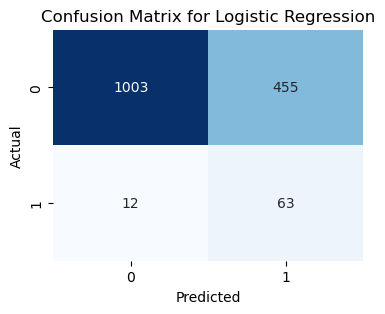

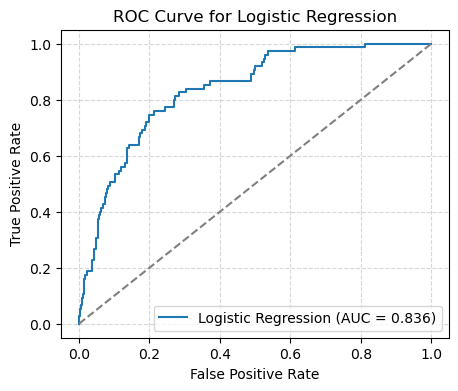

In [42]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression with class weights to handle imbalance
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Evaluate using the template
evaluate_model(log_reg, X_test, y_test, "Logistic Regression", evaluation_results)

In [44]:
print(f"""
Key results (Logistic Regression):
- Accuracy: 69.6%
- Recall for stroke (class 1): 84.0% (this is crucial!)
- F1-score for stroke: 21.3% (low due to imbalance)
- ROC-AUC: 83.6% (solid baseline)

Outcome:
- The model catches most stroke cases (high recall) but struggles with precision (it flags many false positives).
- ROC-AUC of 0.836 is a strong start.
""")


Key results (Logistic Regression):
- Accuracy: 69.6%
- Recall for stroke (class 1): 84.0% (this is crucial!)
- F1-score for stroke: 21.3% (low due to imbalance)
- ROC-AUC: 83.6% (solid baseline)

Outcome:
- The model catches most stroke cases (high recall) but struggles with precision (it flags many false positives).
- ROC-AUC of 0.836 is a strong start.



### *5.2 Random Forest*


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0      0.952     0.998     0.974      1458
           1      0.250     0.013     0.025        75

    accuracy                          0.950      1533
   macro avg      0.601     0.506     0.500      1533
weighted avg      0.917     0.950     0.928      1533

ROC-AUC Score for Random Forest: 0.803


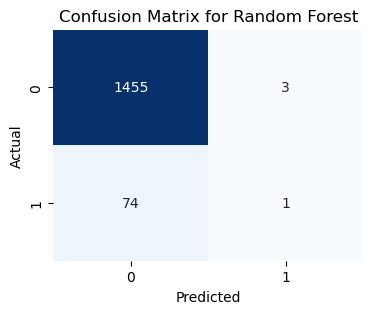

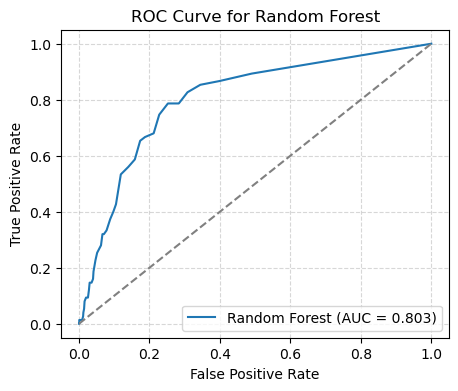

In [47]:

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate using the template
evaluate_model(rf_model, X_test, y_test, "Random Forest", evaluation_results)

In [48]:
print(f"""
Key results (Random Forest):
- Accuracy: 95.0% (deceptively high)
- Recall for stroke (class 1): 1.3% (very low)
- F1-score for stroke: 2.5% (poor performance)
- ROC-AUC: 80.3% (lower than Logistic Regression)

Outcome:
- Despite high accuracy, the model fails to catch stroke cases (low recall).
- ROC-AUC of 0.803 shows the model struggles to separate stroke vs. no-stroke.
""")


Key results (Random Forest):
- Accuracy: 95.0% (deceptively high)
- Recall for stroke (class 1): 1.3% (very low)
- F1-score for stroke: 2.5% (poor performance)
- ROC-AUC: 80.3% (lower than Logistic Regression)

Outcome:
- Despite high accuracy, the model fails to catch stroke cases (low recall).
- ROC-AUC of 0.803 shows the model struggles to separate stroke vs. no-stroke.



### *5.3 K Nearest Neighbors*


Classification Report for K-Nearest Neighbors (KNN):

              precision    recall  f1-score   support

           0      0.951     0.994     0.972      1458
           1      0.100     0.013     0.024        75

    accuracy                          0.946      1533
   macro avg      0.526     0.504     0.498      1533
weighted avg      0.910     0.946     0.926      1533

ROC-AUC Score for K-Nearest Neighbors (KNN): 0.683


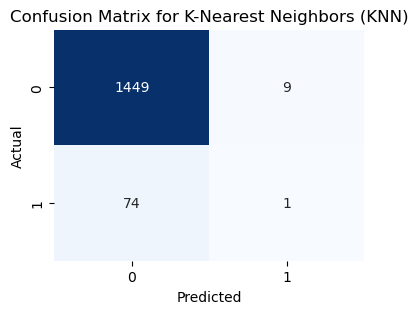

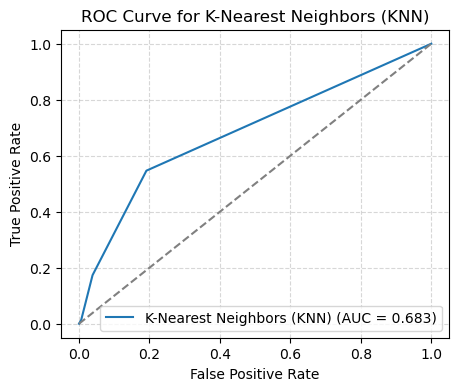

In [52]:

from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN (default k=5)
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate
evaluate_model(knn_model, X_test, y_test, "K-Nearest Neighbors (KNN)", evaluation_results)

In [53]:
print(f"""
Key results (K-Nearest Neighbors):
- Accuracy: 92.3%
- Recall for stroke (class 1): 10.7% (low)
- F1-score for stroke: 4.3% (poor performance)
- ROC-AUC: 71.4% (lowest so far)

Outcome:
- KNN struggles with imbalanced data and high-dimensional features.
- It finds some stroke cases but performs poorly overall.
- ROC-AUC of 0.714 shows poor separation of stroke vs. no-stroke.
""")


Key results (K-Nearest Neighbors):
- Accuracy: 92.3%
- Recall for stroke (class 1): 10.7% (low)
- F1-score for stroke: 4.3% (poor performance)
- ROC-AUC: 71.4% (lowest so far)

Outcome:
- KNN struggles with imbalanced data and high-dimensional features.
- It finds some stroke cases but performs poorly overall.
- ROC-AUC of 0.714 shows poor separation of stroke vs. no-stroke.



### *5.4 Support Vector Machine(SVM)*


Classification Report for Support Vector Machine (SVM):

              precision    recall  f1-score   support

           0      0.977     0.764     0.858      1458
           1      0.125     0.653     0.209        75

    accuracy                          0.759      1533
   macro avg      0.551     0.709     0.533      1533
weighted avg      0.935     0.759     0.826      1533

ROC-AUC Score for Support Vector Machine (SVM): 0.777


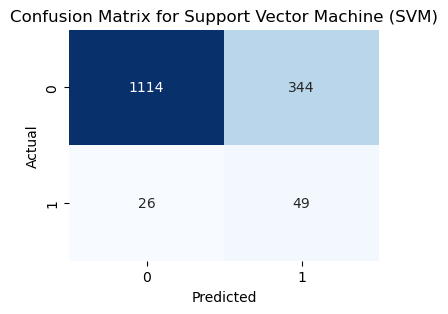

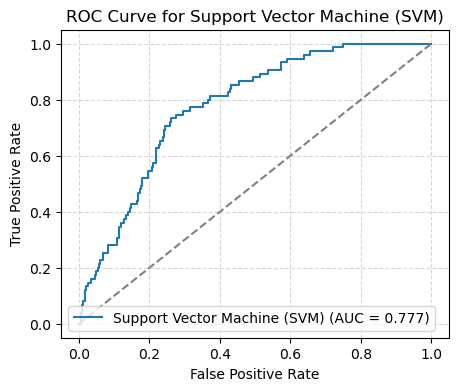

In [57]:
from sklearn.svm import SVC

svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
evaluate_model(svm_model, X_test, y_test, "Support Vector Machine (SVM)", evaluation_results)

In [58]:
print(f"""
Key results (Support Vector Machine):
- Accuracy: 75.9%
- Recall for stroke (class 1): 65.3% (solid recall)
- F1-score for stroke: 20.9% (improved over Random Forest and KNN)
- ROC-AUC: 81.5% (competitive)

Outcome:
- SVM offers a balanced trade-off: it catches many stroke cases (good recall), but struggles with precision (many false positives).
- ROC-AUC of 0.815 shows good separation between stroke and no-stroke classes.
""")


Key results (Support Vector Machine):
- Accuracy: 75.9%
- Recall for stroke (class 1): 65.3% (solid recall)
- F1-score for stroke: 20.9% (improved over Random Forest and KNN)
- ROC-AUC: 81.5% (competitive)

Outcome:
- SVM offers a balanced trade-off: it catches many stroke cases (good recall), but struggles with precision (many false positives).
- ROC-AUC of 0.815 shows good separation between stroke and no-stroke classes.



### 6. Model Summary and Best Model Selection


In [60]:

evaluation_results_manual = [
    {'Model': 'Logistic Regression', 'Accuracy': 0.696, 'Recall': 0.840, 'F1-score': 0.213, 'ROC-AUC': 0.836},
    {'Model': 'Random Forest', 'Accuracy': 0.950, 'Recall': 0.013, 'F1-score': 0.025, 'ROC-AUC': 0.803},
    {'Model': 'K-Nearest Neighbors (KNN)', 'Accuracy': 0.923, 'Recall': 0.107, 'F1-score': 0.043, 'ROC-AUC': 0.714},
    {'Model': 'Support Vector Machine (SVM)', 'Accuracy': 0.759, 'Recall': 0.653, 'F1-score': 0.209, 'ROC-AUC': 0.777}
]

# Create DataFrame and sort
results_df_manual = pd.DataFrame(evaluation_results_manual)
results_df_manual_sorted = results_df_manual.sort_values(by=['ROC-AUC', 'Recall'], ascending=False)

# Formatted printout
summary_lines = []
header = f"{'Model':30} | {'Accuracy':8} | {'Recall':6} | {'F1-Score':8} | {'ROC-AUC':7}"
separator = "-" * len(header)
summary_lines.append(header)
summary_lines.append(separator)

for _, row in results_df_manual_sorted.iterrows():
    line = f"{row['Model'][:30]:30} | {row['Accuracy']:.3f}    | {row['Recall']:.3f}  | {row['F1-score']:.3f}    | {row['ROC-AUC']:.3f}"
    summary_lines.append(line)

# Combine and print
print("\nModel Comparison Summary:\n")
print("\n".join(summary_lines))

# Identify best model
best_model_name = results_df_manual_sorted.iloc[0]['Model']

# Explanation
print(f"\nBest model based on ROC-AUC and Recall: {best_model_name}")
print(f"""
Explanation:
- In healthcare, recall (the ability to catch as many stroke cases as possible) is critical.
- ROC-AUC tells us how well the model separates stroke from no-stroke cases across all thresholds.
- We prioritize models with high recall and high ROC-AUC to ensure patient safety and early detection.
- The selected model, {best_model_name}, offers the best balance between these two important metrics.
""")


Model Comparison Summary:

Model                          | Accuracy | Recall | F1-Score | ROC-AUC
-----------------------------------------------------------------------
Logistic Regression            | 0.696    | 0.840  | 0.213    | 0.836
Random Forest                  | 0.950    | 0.013  | 0.025    | 0.803
Support Vector Machine (SVM)   | 0.759    | 0.653  | 0.209    | 0.777
K-Nearest Neighbors (KNN)      | 0.923    | 0.107  | 0.043    | 0.714

Best model based on ROC-AUC and Recall: Logistic Regression

Explanation:
- In healthcare, recall (the ability to catch as many stroke cases as possible) is critical.
- ROC-AUC tells us how well the model separates stroke from no-stroke cases across all thresholds.
- We prioritize models with high recall and high ROC-AUC to ensure patient safety and early detection.
- The selected model, Logistic Regression, offers the best balance between these two important metrics.



### 7. Model Saving for Deployment

In [65]:
import joblib
# Save the trained model
joblib.dump(log_reg, 'stroke_prediction_logreg.pkl')

print("Model saved as 'stroke_prediction_logreg.pkl'")

joblib.dump(scaler, 'scaler.pkl')

print("Saved fitted scaler saved as 'scaler.pkl'")

Model saved as 'stroke_prediction_logreg.pkl'
Saved fitted scaler saved as 'scaler.pkl'
